In [1]:
import pandas as pd
import os
import re
import numpy as np
import networkx
from networkx.algorithms.components.connected import connected_components
from collections import defaultdict
import seaborn as sns
sns.set()

In [2]:
nodes_df = pd.read_csv('./bigscape_outputs/network_files/2020-05-16_22-19-49_hybrids_glocal/Network_Annotations_Full.tsv',sep='\t')

nodes_df = nodes_df.drop('Organism',axis=1)

nodes_df[:5]

,BGC,Accesion ID,Description,Product Prediction,BiG-SCAPE class,Taxonomy
0,AADV02000001.1.region001,AADV02000001.1,AADV02000001.1 Crocosphaera watsonii WH 8501 c...,NRPS.terpene,Others,NaN
1,AADV02000001.1.region002,AADV02000001.1,AADV02000001.1 Crocosphaera watsonii WH 8501 c...,NRPS,NRPS,NaN
2,AADV02000002.1.region001,AADV02000002.1,AADV02000002.1 Crocosphaera watsonii WH 8501 c...,NRPS.T1PKS,PKS-NRP_Hybrids,NaN
3,AADV02000004.1.region001,AADV02000004.1,AADV02000004.1 Crocosphaera watsonii WH 8501 c...,NRPS,NRPS,NaN
4,AADV02000005.1.region001,AADV02000005.1,AADV02000005.1 Crocosphaera watsonii WH 8501 c...,NRPS,NRPS,NaN


In [3]:
len(nodes_df)

13986

**Relacing Name**

In [6]:
def parse_gbk_list(folder_list):
    gbk_list,new_name_list = [],[]
    for antismash_folder in folder_list:
        for root, dirs, files in os.walk(antismash_folder):
            count = 1
            for file in sorted(files):
                if file.endswith(".gbk"):
                    if 'region' in file:
                        if 'BGC' in file:
                            new_name = file.rstrip('.gbk')
                            new_name_list.append(new_name)
                            gbk_list.append(file.rstrip('.gbk'))
                        else:
                            strain_name = os.path.basename(os.path.normpath(root)).split('.')[0]
                            gbk_list.append(file.rstrip('.gbk'))
                            new_name = strain_name + '.region' + "{0:0=3d}".format(count)
                            count += 1
                            new_name_list.append(new_name)
    return gbk_list,new_name_list

folder_list = ["/Users/tiagoferreiraleao/tiago-NAS/cyanobiome/ncbi_antismash/nf_output/"]

gbk_list,new_name_list = parse_gbk_list(folder_list)

In [7]:
name_dict = dict(zip(gbk_list, new_name_list))
new_col1 = []

for i,r in nodes_df.iterrows():
    new_col1.append(name_dict[nodes_df['BGC'].loc[i]])
    
nodes_df['BGC'] = new_col1

nodes_df[:5]

,BGC,Accesion ID,Description,Product Prediction,BiG-SCAPE class,Taxonomy
0,AADV02.region001,AADV02000001.1,AADV02000001.1 Crocosphaera watsonii WH 8501 c...,NRPS.terpene,Others,NaN
1,AADV02.region002,AADV02000001.1,AADV02000001.1 Crocosphaera watsonii WH 8501 c...,NRPS,NRPS,NaN
2,AADV02.region003,AADV02000002.1,AADV02000002.1 Crocosphaera watsonii WH 8501 c...,NRPS.T1PKS,PKS-NRP_Hybrids,NaN
3,AADV02.region004,AADV02000004.1,AADV02000004.1 Crocosphaera watsonii WH 8501 c...,NRPS,NRPS,NaN
4,AADV02.region005,AADV02000005.1,AADV02000005.1 Crocosphaera watsonii WH 8501 c...,NRPS,NRPS,NaN


**Obtaining Taxonomy**

In [8]:
taxa_list = []

for i,r in nodes_df.iterrows():
    taxa_line = nodes_df['Description'].loc[i]
    if 'TPA_asm:' in str(taxa_line):
        taxa = taxa_line.split(' ')[2]
    if 'uncultured' in str(taxa_line):
        taxa = taxa_line.split(' ')[2]
    if 'TPA_asm:' not in str(taxa_line) and 'uncultured' not in str(taxa_line):
        taxa = taxa_line.split(' ')[1]
    taxa_list.append(taxa)
    
nodes_df['Taxonomy'] = taxa_list

nodes_df[:5]

,BGC,Accesion ID,Description,Product Prediction,BiG-SCAPE class,Taxonomy
0,AADV02.region001,AADV02000001.1,AADV02000001.1 Crocosphaera watsonii WH 8501 c...,NRPS.terpene,Others,Crocosphaera
1,AADV02.region002,AADV02000001.1,AADV02000001.1 Crocosphaera watsonii WH 8501 c...,NRPS,NRPS,Crocosphaera
2,AADV02.region003,AADV02000002.1,AADV02000002.1 Crocosphaera watsonii WH 8501 c...,NRPS.T1PKS,PKS-NRP_Hybrids,Crocosphaera
3,AADV02.region004,AADV02000004.1,AADV02000004.1 Crocosphaera watsonii WH 8501 c...,NRPS,NRPS,Crocosphaera
4,AADV02.region005,AADV02000005.1,AADV02000005.1 Crocosphaera watsonii WH 8501 c...,NRPS,NRPS,Crocosphaera


In [9]:
def get_neighbors(target,dataframe,column1,column2):
    subset1 = dataframe[(dataframe[column1]==target)]
    subcat = subset1.append(dataframe[(dataframe[column2]==target)])
    temp_list = []
    for index,row in subcat.iterrows():
        temp_list.append(subcat[column1][index])
        temp_list.append(subcat[column2][index])
    temp_list = list(np.unique(temp_list))
    return temp_list

def to_edges(l):
    '''This function convert a list of group of nodes into edges
    Script adapted from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements/4842783
    '''
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current

def to_graph(l):
    '''This function generate a graph using a list of group of nodes and the edges create with the function to_edges()
    Script adapted from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements/4842783
    '''
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def get_family_dict(components_list,dataframe,dictionary):
    count = 0
    for family in list(components_list):
        count += 1
        for fam_member in family:
            dictionary['GCF%s'%count].append(fam_member)
    return dictionary

def main_get_families(input_file,bigscape_df):
    targets_list = np.unique([bigscape_df.Clustername_1,bigscape_df.Clustername_2])
    neighbors_list = []
    for target in targets_list:
        neighbors_list.append(get_neighbors(target,bigscape_df,'Clustername_1','Clustername_2'))
    G = to_graph(neighbors_list)
    C = connected_components(G)
    gcf_dict = defaultdict(list)
    gcf_dict = get_family_dict(C,bigscape_df,gcf_dict)
    return gcf_dict

In [10]:
def get_bigscape_df(input_file):
    bigscape_df = pd.read_csv(input_file,sep='\t')
    bigscape_df.rename(columns=lambda x: re.sub(' ','_',x), inplace=True)
    bigscape_df = bigscape_df[bigscape_df.Clustername_1 != bigscape_df.Clustername_2]
    bigscape_df.reset_index(inplace=True,drop=True)
    return bigscape_df

bigscape_df = get_bigscape_df("./bigscape_outputs/bigscape_all_c030.txt")

name_dict = dict(zip(gbk_list, new_name_list))
new_col1, new_col2 = [],[]

for i,r in bigscape_df.iterrows():
    new_col1.append(name_dict[bigscape_df['Clustername_1'].loc[i]])
    new_col2.append(name_dict[bigscape_df['Clustername_2'].loc[i]])
    
bigscape_df['Clustername_1'] = new_col1
bigscape_df['Clustername_2'] = new_col2

gcf_dict = main_get_families('./bigscape_outputs/bigscape_all_c030.txt',bigscape_df)

In [11]:
gcf_dict

defaultdict(list,
            {'GCF1': ['CAQK01.region015',
              'AADV02.region001',
              '.region001',
              'CAQM01.region009',
              'CAQL01.region002',
              'AESD01.region003'],
             'GCF2': ['CAQN01.region009',
              'CAQM01.region001',
              'AADV02.region002',
              'AGJC02.region007',
              'CAQK01.region019',
              'CAQN01.region019',
              'CAQL01.region020',
              'CAQM01.region002',
              'AESD01.region004',
              'CAQL01.region011',
              'AESD01.region013'],
             'GCF3': ['CAQM01.region006', 'AADV02.region007'],
             'GCF4': ['PRLH01.region005',
              'AAXW01.region005',
              'CAQK01.region008',
              'CAQL01.region009',
              'AESD01.region012',
              'CAQN01.region014',
              'NETF01.region004',
              'CAQM01.region003',
              'AGJC02.region006',
              '

In [12]:
col1,col2,col3 = [],[],[]

type_dict = dict(zip(nodes_df['BGC'],nodes_df['Product Prediction']))

def most_frequent(List): 
    return max(set(List), key = List.count) 

for gcf in gcf_dict:
    col1.append(gcf)
    temp_type_list = []
    for item in gcf_dict[gcf]:
        if item in type_dict:
            temp_type_list.append(type_dict[item])
    consensus_taxa = most_frequent(temp_type_list)
    col2.append(consensus_taxa)
    col3.append(len(temp_type_list))
    
frames = {'GCF':col1,'Type':col2,'BGC_count':col3}

gcf_metadata = pd.DataFrame(frames)

gcf_metadata

,GCF,Type,BGC_count
0,GCF1,terpene,5
1,GCF2,NRPS,11
2,GCF3,NRPS,2
3,GCF4,terpene,10
4,GCF5,NRPS-like,7
...,...,...,...
1079,GCF1080,TfuA-related,3
1080,GCF1081,bacteriocin.lanthipeptide,2
1081,GCF1082,cyanobactin.LAP,2
1082,GCF1083,terpene,3


In [22]:
sum_col1,sum_col2 = [],[]

for item in np.unique(gcf_metadata['Type']):
    temp_df = gcf_metadata[gcf_metadata['Type'] == item]
    sum_col1.append(item)
    sum_col2.append(len(temp_df))

frames = {'Type':sum_col1,'Count':sum_col2}

metadata_sum = pd.DataFrame(frames)

metadata_sum = metadata_sum.sort_values(by='Count',)

metadata_sum = metadata_sum[metadata_sum['Count'] > 9]

metadata_sum

,Type,Count
52,lanthipeptide,10
46,hglE-KS,10
30,T3PKS,12
53,lassopeptide,15
54,microviridin,15
39,bacteriocin.lanthipeptide,18
41,cyanobactin,23
27,T1PKS,55
11,NRPS.T1PKS,58
3,NRPS-like,66


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text xticklabel objects>)

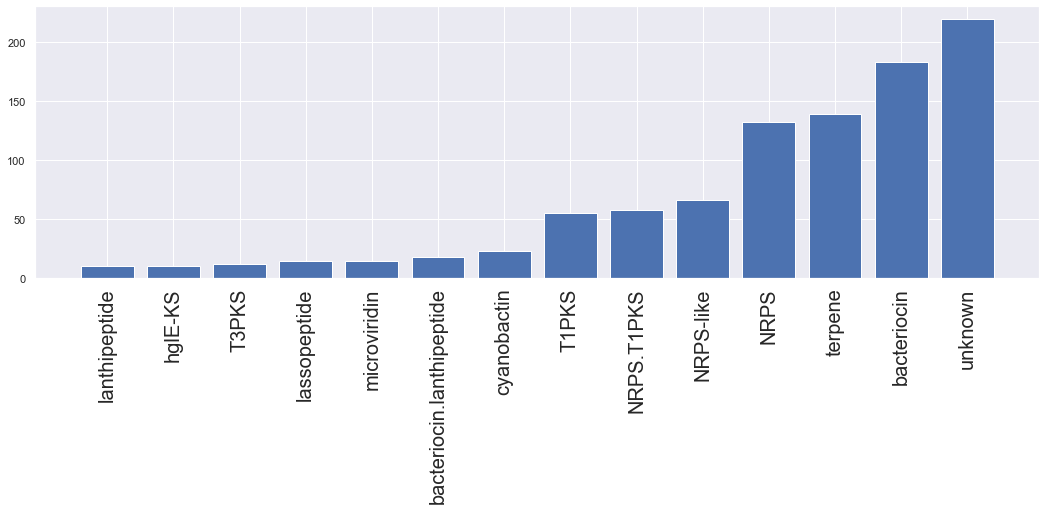

In [24]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(18,5))

plt.bar(metadata_sum['Type'],metadata_sum['Count'])
plt.xticks(rotation=90,fontsize=20)
# metadata_sum.plot.bar(x='Type')

In [122]:
cyanobiome_list = ['JAAHII01','JAAHIH01','JAAHGF01','JAAHHC01','JAAHHD01','JAAHFN01','JAAHGM01','JAAHGB01','JAAHFW01','JAAHFZ01','JAAHFP01','JAAHGH01','JAAHGC01','JAAHGA01','JAAHHJ01','JAAHGO01','JAAHGU01','JAAHGW01','JAAHGS01','JAAHHM01','JAAHHP01','JAAHHN01','JAAHGL01','JAAHFU01']

In [123]:
col1,col2,col3 = [],[],[]

type_dict = dict(zip(nodes_df['BGC'],nodes_df['Product Prediction']))

def most_frequent(List): 
    return max(set(List), key = List.count) 

for gcf in gcf_dict:
    temp_type_list = []
    for item in gcf_dict[gcf]:
        if item in type_dict:
            if str(item.split('.')[0]) in cyanobiome_list:
                temp_type_list.append(type_dict[item])
    if len(temp_type_list) > 0:
        col1.append(gcf)
        consensus_taxa = most_frequent(temp_type_list)
        col2.append(consensus_taxa)
        col3.append(len(temp_type_list))
    
frames = {'GCF':col1,'Type':col2,'BGC_count':col3}

gcf_metadata = pd.DataFrame(frames)

gcf_metadata

,GCF,Type,BGC_count
0,GCF24,terpene,19
1,GCF26,lassopeptide,14
2,GCF53,bacteriocin.lanthipeptide,3
3,GCF54,bacteriocin,6
4,GCF55,NRPS-like,4
...,...,...,...
114,GCF838,terpene,1
115,GCF845,lanthipeptide,1
116,GCF856,NRPS,1
117,GCF857,terpene,1


In [124]:
sum_col1,sum_col2 = [],[]

for item in np.unique(gcf_metadata['Type']):
    temp_df = gcf_metadata[gcf_metadata['Type'] == item]
    sum_col1.append(item)
    sum_col2.append(len(temp_df))

frames = {'Type':sum_col1,'Count':sum_col2}

metadata_sum = pd.DataFrame(frames)

metadata_sum = metadata_sum.sort_index(by='Count')

metadata_sum = metadata_sum[metadata_sum['Count'] > 2]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if sys.path[0] == '':


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

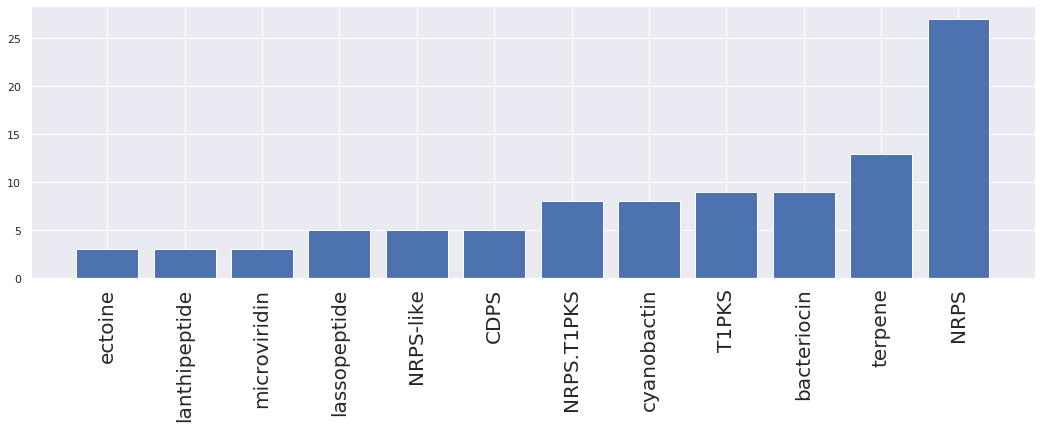

In [125]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(18,5))

plt.bar(metadata_sum['Type'],metadata_sum['Count'])
plt.xticks(rotation=90,fontsize=20)
# metadata_sum.plot.bar(x='Type')